In [3098]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_columns=50
from matplotlib import style
style.use('ggplot')
from scipy import stats
from time import time

from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

In [3099]:
train = pd.read_csv("C:/Users/kulka/Desktop/AV_Hackathon_Codes/Jobathon/Data/train_Df64byy.csv")
test  = pd.read_csv("C:/Users/kulka/Desktop/AV_Hackathon_Codes/Jobathon/Data/test_YCcRUnU.csv")

In [3100]:
print ("Training Data Shape:{}".format(train.shape))
print ("Testing Data Shape:{}".format(test.shape))

Training Data Shape:(50882, 14)
Testing Data Shape:(21805, 13)


In [3101]:
print ("Unique ID's in Training Data:{}".format(train['ID'].nunique()))
print ("Unique ID's in Testing Data:{}".format(test['ID'].nunique()))

Unique ID's in Training Data:50882
Unique ID's in Testing Data:21805


In [3102]:
Submission = test[['ID']]

In [3103]:
train.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [3104]:
test.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,50883,C1,156,Owned,Individual,30,30,No,NaN,6.0,3.0,5,11934.0
1,50884,C4,7,Owned,Joint,69,68,Yes,X1,3.0,3.0,18,32204.8
2,50885,C1,564,Rented,Individual,28,28,No,X3,2.0,4.0,17,9240.0
3,50886,C3,1177,Rented,Individual,23,23,No,X3,3.0,3.0,18,9086.0
4,50887,C1,951,Owned,Individual,75,75,No,X3,NaN,NaN,5,22534.0


In [3105]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(2), int64(6

In [3106]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21805 entries, 0 to 21804
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       21805 non-null  int64  
 1   City_Code                21805 non-null  object 
 2   Region_Code              21805 non-null  int64  
 3   Accomodation_Type        21805 non-null  object 
 4   Reco_Insurance_Type      21805 non-null  object 
 5   Upper_Age                21805 non-null  int64  
 6   Lower_Age                21805 non-null  int64  
 7   Is_Spouse                21805 non-null  object 
 8   Health Indicator         16778 non-null  object 
 9   Holding_Policy_Duration  13202 non-null  object 
 10  Holding_Policy_Type      13202 non-null  float64
 11  Reco_Policy_Cat          21805 non-null  int64  
 12  Reco_Policy_Premium      21805 non-null  float64
dtypes: float64(2), int64(5), object(6)
memory usage: 2.2+ MB


1. From the above information, we can see that most of the variables are of Object data type followed by integer and floating point values.
2. We can also see that there are missing values in Health Indicator, Holding_Policy_Duration, Holding_Policy_Type, variables.

### EDA (Training Data)

#### Univariate Analysis

#### Dependent Variable

In [3107]:
train['Response'].value_counts(dropna=False)/len(train)

0    0.760053
1    0.239947
Name: Response, dtype: float64

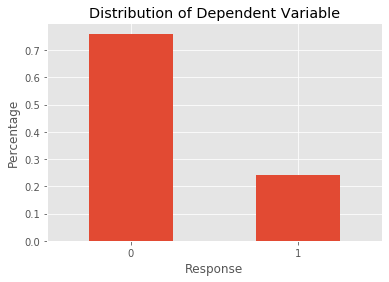

In [3108]:
(train['Response'].value_counts(dropna=False)/len(train)).plot.bar();
plt.title("Distribution of Dependent Variable");
plt.xlabel("Response");
plt.ylabel("Percentage");
plt.xticks(rotation=360);

1. We can see that 76% of the responses are Negative and the remaining are Positive.
2. So the response variable cannot be considered to be extremely imbalanced, although there is imbalance in the response variable.

#### Independent Variables

In [3109]:
train['City_Code'].nunique(),test['City_Code'].nunique()

(36, 36)

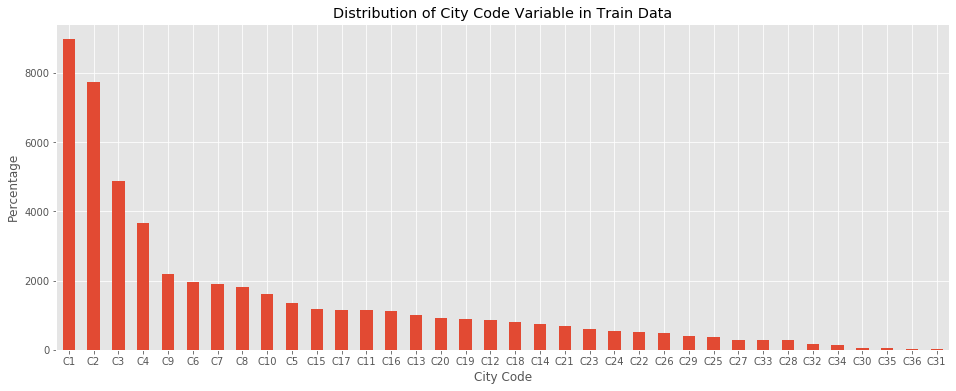

In [3110]:
plt.figure(figsize=(16,6));
train['City_Code'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of City Code Variable in Train Data");
plt.xlabel("City Code");
plt.ylabel("Percentage");
plt.xticks(rotation=360);

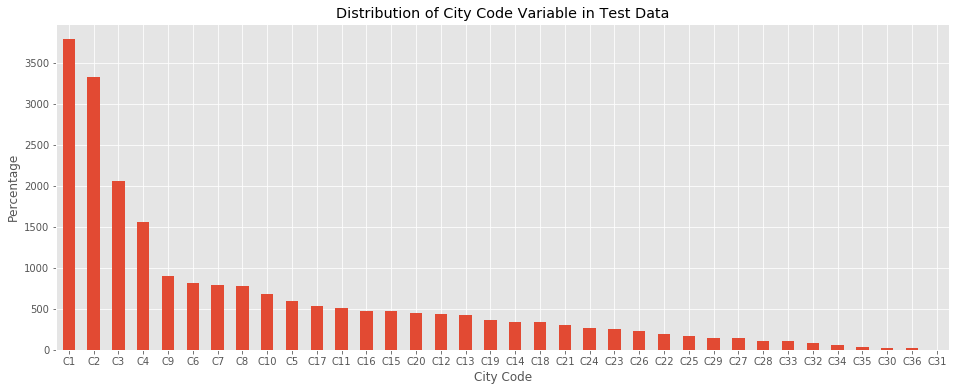

In [3111]:
plt.figure(figsize=(16,6));
test['City_Code'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of City Code Variable in Test Data");
plt.xlabel("City Code");
plt.ylabel("Percentage");
plt.xticks(rotation=360);

1. There are 36 unique City Codes available.
2. C1, C2, C3 and C4 seem to be the most popular city codes.
3. Some of the city codes have very less count. Some of them can be combined.

In [3112]:
train['Region_Code'].nunique(),test['Region_Code'].nunique()

(5316, 4694)

In [3113]:
train['Region_Code'].value_counts(dropna=False).head(10)

1     96
5     75
2     73
6     73
4     73
10    69
8     64
7     64
16    61
20    58
Name: Region_Code, dtype: int64

In [3114]:
test['Region_Code'].value_counts(dropna=False).head(10)

1     44
2     39
7     35
26    33
40    31
5     30
6     29
4     29
8     28
37    27
Name: Region_Code, dtype: int64

In [3115]:
# Dropping the region_code values that are in the train dataset and not in test dataset
train.drop(train[train.Region_Code.isin(list(set(list(train['Region_Code']))-set(list(test['Region_Code']))))].index,axis=0,inplace=True)

1. Region Code variable has 5316 unique values.
2. Region code 1 seems to be the most popular one. Some of them just have 1 count.

In [3116]:
train['Accomodation_Type'].nunique(),test['Accomodation_Type'].nunique()

(2, 2)

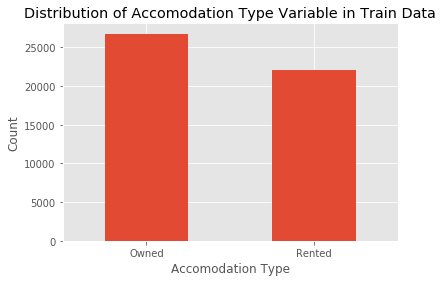

In [3117]:
train['Accomodation_Type'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Accomodation Type Variable in Train Data");
plt.xlabel("Accomodation Type");
plt.ylabel("Count");
plt.xticks(rotation=360);

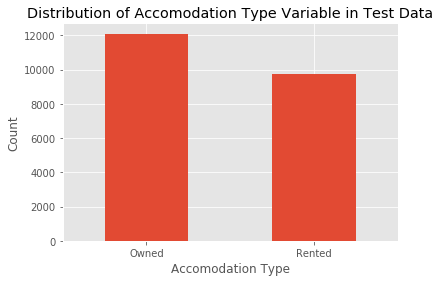

In [3118]:
test['Accomodation_Type'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Accomodation Type Variable in Test Data");
plt.xlabel("Accomodation Type");
plt.ylabel("Count");
plt.xticks(rotation=360);

1. Accomodation Type variable has just 2 unique values, Owned or Rented. Most of the customer own the accomodation.

In [3119]:
train['Reco_Insurance_Type'].nunique(),test['Reco_Insurance_Type'].nunique()

(2, 2)

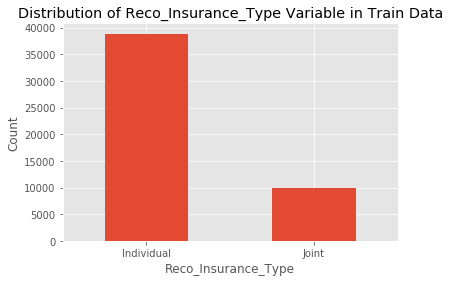

In [3120]:
train['Reco_Insurance_Type'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Reco_Insurance_Type Variable in Train Data");
plt.xlabel("Reco_Insurance_Type");
plt.ylabel("Count");
plt.xticks(rotation=360);

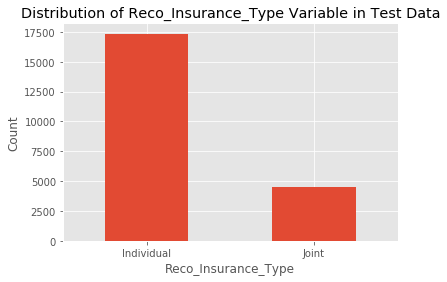

In [3121]:
test['Reco_Insurance_Type'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Reco_Insurance_Type Variable in Test Data");
plt.xlabel("Reco_Insurance_Type");
plt.ylabel("Count");
plt.xticks(rotation=360);

1. Most of the recommended Insurance types are Individual and some are Joint. The difference in the suggestions are clear. 

In [3122]:
train[['Upper_Age',"Lower_Age"]].describe()

,Upper_Age,Lower_Age
count,48752.000000,48752.000000
mean,44.820254,42.707068
std,17.312920,17.322824
min,18.000000,16.000000
25%,28.000000,27.000000
50%,44.000000,40.000000
75%,59.000000,57.000000
max,75.000000,75.000000


In [3123]:
test[['Upper_Age',"Lower_Age"]].describe()

,Upper_Age,Lower_Age
count,21805.000000,21805.000000
mean,44.877734,42.748085
std,17.254898,17.269112
min,18.000000,16.000000
25%,28.000000,27.000000
50%,44.000000,41.000000
75%,59.000000,57.000000
max,75.000000,75.000000


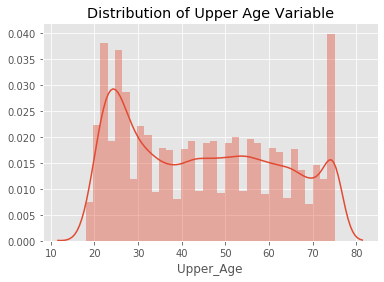

In [3124]:
sns.distplot(train['Upper_Age']);
plt.title("Distribution of Upper Age Variable");

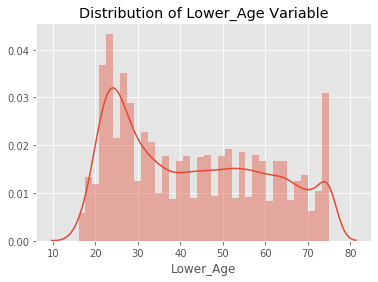

In [3125]:
sns.distplot(train['Lower_Age']);
plt.title("Distribution of Lower_Age Variable");

1. We can see that the distributions of both Upper_Age and Lower_Age look similar.
2. We can see that the mean Upper_Age is slightl higher than mean Lower_Age. 
3. The maximum age of both Upper_Age and Lower_Age is the same. 
4. One thing we can make out is that for Individual Reco_Insurance_Type, both Lower_Age and Upper_Age will be the same.

In [3126]:
train['Is_Spouse'].nunique(), test['Is_Spouse'].nunique()

(2, 2)

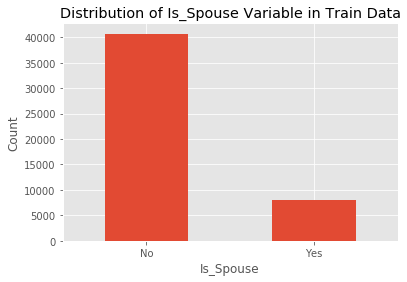

In [3127]:
train['Is_Spouse'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Is_Spouse Variable in Train Data");
plt.xlabel("Is_Spouse");
plt.ylabel("Count");
plt.xticks(rotation=360);

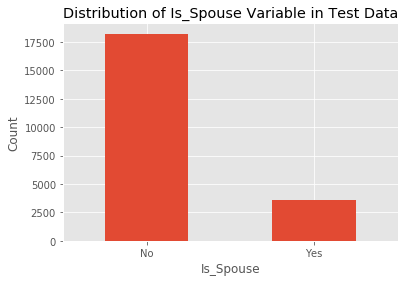

In [3128]:
test['Is_Spouse'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Is_Spouse Variable in Test Data");
plt.xlabel("Is_Spouse");
plt.ylabel("Count");
plt.xticks(rotation=360);

1. If the information given in the Data Dictionary is correct, the count of Is_Spouse="Yes" should be the same as the count of Reco_Insurance_Type="Joint".
2. Since most of the Reco_Insurance_Type are Individual, most of the Is_Spouse will be No.

In [3129]:
train['Health Indicator'].nunique(), test['Health Indicator'].nunique()

(9, 9)

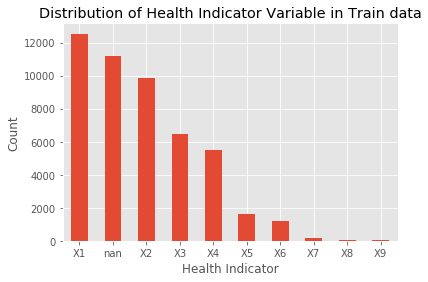

In [3130]:
train['Health Indicator'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Health Indicator Variable in Train data");
plt.xlabel("Health Indicator");
plt.ylabel("Count");
plt.xticks(rotation=360);

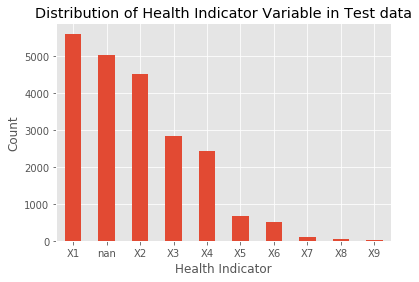

In [3131]:
test['Health Indicator'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Health Indicator Variable in Test data");
plt.xlabel("Health Indicator");
plt.ylabel("Count");
plt.xticks(rotation=360);

1. As per the data dictionary, this is an encoded variable, meaning we do not know the meaning of these values.
2. X1 seems to be the most popular Health Indicator type.
3. We also have a lot of missing values here, we can explore further the cause of so many missing values. 

In [3132]:
train['Holding_Policy_Duration'].unique(), test['Holding_Policy_Duration'].unique()

(array(['14+', nan, '1.0', '3.0', '5.0', '9.0', '14.0', '7.0', '2.0',
        '11.0', '10.0', '8.0', '6.0', '4.0', '13.0', '12.0'], dtype=object),
 array(['6.0', '3.0', '2.0', nan, '14+', '5.0', '1.0', '4.0', '12.0',
        '11.0', '7.0', '9.0', '13.0', '8.0', '14.0', '10.0'], dtype=object))

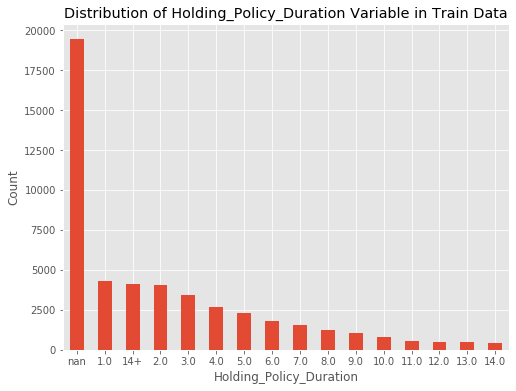

In [3133]:
plt.figure(figsize=(8,6));
train['Holding_Policy_Duration'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Holding_Policy_Duration Variable in Train Data");
plt.xlabel("Holding_Policy_Duration");
plt.ylabel("Count");
plt.xticks(rotation=360);

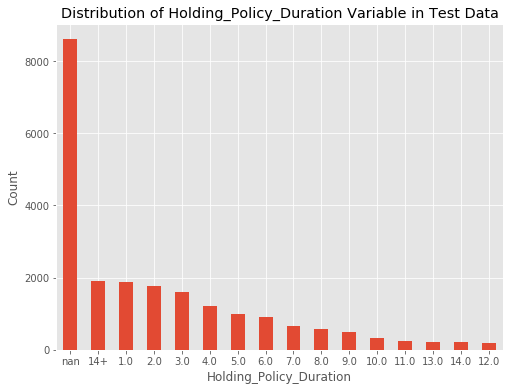

In [3134]:
plt.figure(figsize=(8,6));
test['Holding_Policy_Duration'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Holding_Policy_Duration Variable in Test Data");
plt.xlabel("Holding_Policy_Duration");
plt.ylabel("Count");
plt.xticks(rotation=360);

1. We can see that this variable has a lot of missing values (majority of them).
2. Most of the existing customers seem to be holding a policy with the company for 1 year followed by 14+ years followed by 2 years. 
3. 14+ can be imputed with 15 so that the variable is considered of numeric data type and not object. This can be explored further.

In [3135]:
train['Holding_Policy_Type'].nunique(), test['Holding_Policy_Type'].nunique()

(4, 4)

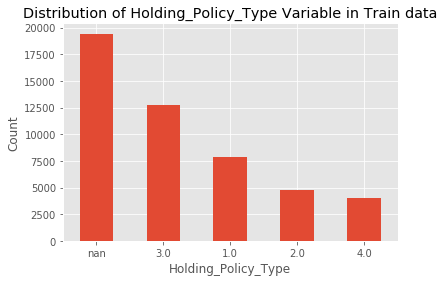

In [3136]:
train['Holding_Policy_Type'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Holding_Policy_Type Variable in Train data");
plt.xlabel("Holding_Policy_Type");
plt.ylabel("Count");
plt.xticks(rotation=360);

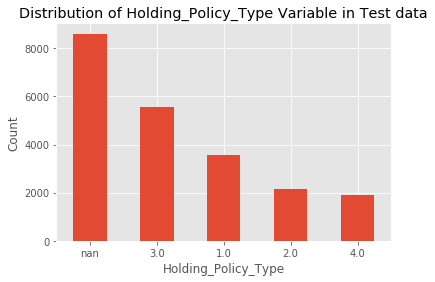

In [3137]:
test['Holding_Policy_Type'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Holding_Policy_Type Variable in Test data");
plt.xlabel("Holding_Policy_Type");
plt.ylabel("Count");
plt.xticks(rotation=360);

1. This variable has a lot of missing values. 
2. Holding_Policy_Type, Holding_Policy_Duration variables have same number of missing values which makes sense because if the person is not holding a policy with the company, he will not have the records of policy type and duration of holding the policy.
3. Policy_Type 3 seems to be the most popular policy type followed by type 1.

In [3138]:
train['Reco_Policy_Cat'].nunique(), test['Reco_Policy_Cat'].nunique()

(22, 22)

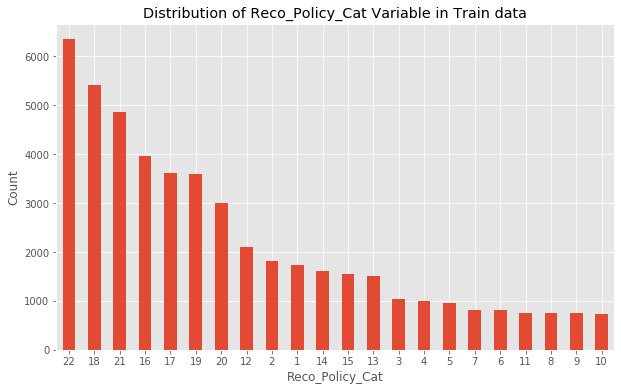

In [3139]:
plt.figure(figsize=(10,6));
train['Reco_Policy_Cat'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Reco_Policy_Cat Variable in Train data");
plt.xlabel("Reco_Policy_Cat");
plt.ylabel("Count");
plt.xticks(rotation=360);

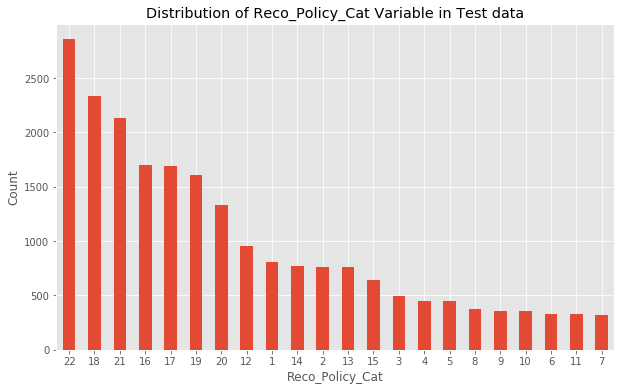

In [3140]:
plt.figure(figsize=(10,6));
test['Reco_Policy_Cat'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Reco_Policy_Cat Variable in Test data");
plt.xlabel("Reco_Policy_Cat");
plt.ylabel("Count");
plt.xticks(rotation=360);

1. There are 22 unique values in the Reco_Policy_Cat variable. 
2. Health Insurance type 22 seems to be the most popular followed by types 18 and 21. 
2. Health Insurance type 10 seems to be least suggested. 

In [3141]:
train['Reco_Policy_Premium'].describe()

count    48752.000000
mean     14183.325468
std       6594.384922
min       2280.000000
25%       9240.000000
50%      13173.600000
75%      18090.000000
max      43350.400000
Name: Reco_Policy_Premium, dtype: float64

In [3142]:
test['Reco_Policy_Premium'].describe()

count    21805.000000
mean     14220.306581
std       6497.996164
min       2152.000000
25%       9285.000000
50%      13244.000000
75%      18201.600000
max      43776.000000
Name: Reco_Policy_Premium, dtype: float64

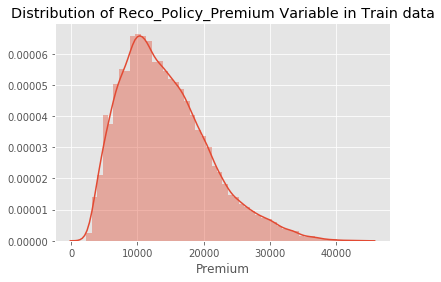

In [3143]:
sns.distplot(train['Reco_Policy_Premium']);
plt.title("Distribution of Reco_Policy_Premium Variable in Train data");
plt.xlabel("Premium");

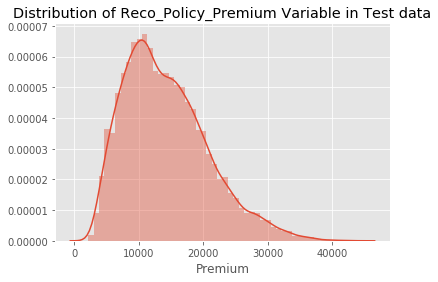

In [3144]:
sns.distplot(test['Reco_Policy_Premium']);
plt.title("Distribution of Reco_Policy_Premium Variable in Test data");
plt.xlabel("Premium");

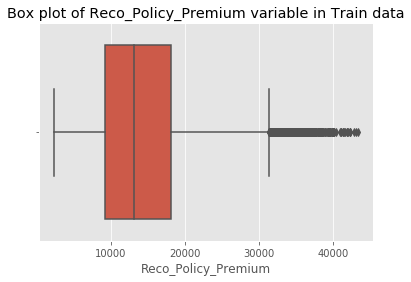

In [3145]:
sns.boxplot(train['Reco_Policy_Premium']);
plt.title("Box plot of Reco_Policy_Premium variable in Train data");

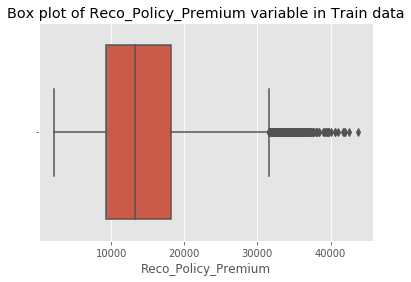

In [3146]:
sns.boxplot(test['Reco_Policy_Premium']);
plt.title("Box plot of Reco_Policy_Premium variable in Train data");

In [3147]:
Q1 = train['Reco_Policy_Premium'].quantile(0.25)
Q3 = train['Reco_Policy_Premium'].quantile(0.75)
IQR = Q3-Q1
print ("Values above {} and Values below {} can be considered as outliers".format(Q3+1.5*IQR,Q1-1.5*IQR))

Values above 31365.0 and Values below -4035.0 can be considered as outliers


In [3148]:
train[(train['Reco_Policy_Premium']<-4024.0)|(train['Reco_Policy_Premium']>31368)]

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
49,50,C1,85,Owned,Joint,73,68,Yes,X2,7.0,4.0,21,31692.8,0
63,64,C1,2980,Owned,Joint,75,74,Yes,X1,5.0,3.0,8,32832.0,0
106,107,C2,1818,Owned,Joint,67,48,No,NaN,NaN,NaN,22,33840.0,0
137,138,C1,1653,Owned,Joint,75,56,Yes,X4,NaN,NaN,5,37878.4,0
174,175,C2,4659,Owned,Joint,74,49,Yes,X1,14+,3.0,18,32544.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50634,50635,C2,3261,Owned,Joint,75,74,Yes,X5,NaN,NaN,22,35532.8,0
50709,50710,C1,69,Owned,Joint,74,73,Yes,NaN,NaN,NaN,17,38304.0,1
50710,50711,C1,1732,Owned,Joint,75,56,Yes,X2,1.0,3.0,7,34998.0,0
50784,50785,C1,3802,Owned,Joint,70,69,Yes,X2,6.0,3.0,2,32857.6,0


1. The distribution seems to be Positively skewed as can be seen above.
2. The average annual premium for suggested health insurance is 14183 rupees.
3. The maximum seems to be 43350 and the median seems to be 13178 and the minimum is 2280. 
4. We can also see some values that are above the accepted range, these can be explored further.

#### Bi-Variate Analysis

In [3149]:
# Lets check the response variable based on the City_Code variable
train.groupby('City_Code')['Response'].mean()

City_Code
C1     0.245033
C10    0.225095
C11    0.242370
C12    0.231953
C13    0.251821
C14    0.235784
C15    0.214978
C16    0.239151
C17    0.225543
C18    0.242507
C19    0.228337
C2     0.243221
C20    0.232877
C21    0.215827
C22    0.234469
C23    0.267380
C24    0.235772
C25    0.238390
C26    0.218814
C27    0.245552
C28    0.232000
C29    0.235450
C3     0.239313
C30    0.307692
C31    0.000000
C32    0.280822
C33    0.240310
C34    0.271318
C35    0.255319
C36    0.125000
C4     0.243759
C5     0.229372
C6     0.236758
C7     0.252842
C8     0.244315
C9     0.232414
Name: Response, dtype: float64

In [3150]:
# Let's check if individuals who own the accomodation are more likely to buy the insurance or those who rent
train.groupby('Accomodation_Type')['Response'].value_counts(dropna=False,normalize=True)

Accomodation_Type  Response
Owned              0           0.758112
                   1           0.241888
Rented             0           0.762682
                   1           0.237318
Name: Response, dtype: float64

We can see that the percentage of customers who showed interest in the insurance policy is almost same for both types of accomodation.

In [3151]:
# Let's check the distribution of response variable based on the recommended insurance type
train.groupby('Reco_Policy_Cat')['Response'].value_counts(dropna=False,normalize=True)

Reco_Policy_Cat  Response
1                0           0.995963
                 1           0.004037
2                0           0.868681
                 1           0.131319
3                0           0.805395
                 1           0.194605
4                0           0.925628
                 1           0.074372
5                0           0.704475
                 1           0.295525
6                0           0.831488
                 1           0.168512
7                0           0.816302
                 1           0.183698
8                0           0.732095
                 1           0.267905
9                0           0.835325
                 1           0.164675
10               0           0.827680
                 1           0.172320
11               0           0.837945
                 1           0.162055
12               0           0.687262
                 1           0.312738
13               0           0.774406
                 1      

In [3152]:
# Let's check the distribution of response variable based on the recommended insurance type
train.groupby('Reco_Insurance_Type')['Response'].value_counts(dropna=False,normalize=True)

Reco_Insurance_Type  Response
Individual           0           0.762641
                     1           0.237359
Joint                0           0.750480
                     1           0.249520
Name: Response, dtype: float64

We can see that the percentage of customers who showed interest in the insurance policy is almost same for both types of recommended insurance.

In [3153]:
# Let's check the distribution of response variable based on the is_spouse variable
train.groupby('Is_Spouse')['Response'].value_counts(normalize=True)

Is_Spouse  Response
No         0           0.761189
           1           0.238811
Yes        0           0.755036
           1           0.244964
Name: Response, dtype: float64

In [3154]:
# Let's check the distribution of response variable based on the health indicator
train.groupby('Health Indicator')['Response'].mean()

Health Indicator
X1    0.244397
X2    0.240542
X3    0.236350
X4    0.242573
X5    0.237835
X6    0.236409
X7    0.324324
X8    0.243243
X9    0.229508
Name: Response, dtype: float64

In [3155]:
train[train['Health Indicator'].isna()]['Response'].value_counts()

0    8578
1    2621
Name: Response, dtype: int64

We can see that the percentage of customers who showed interest in the insurance policy is almost same for all health indicators except for health indicator value X7.

In [3156]:
# Let's see how many existing customers opt for the insurance.
train[train['Holding_Policy_Duration'].notnull()]['Response'].value_counts(normalize=True)

0    0.75943
1    0.24057
Name: Response, dtype: float64

We can see that around 75% of the existing customers do not opt for the health insurance add on. 

In [3157]:
# Let's see the distribution of the response variable based on Recommended_Policy_Category
train.groupby('Reco_Policy_Cat')['Response'].mean().sort_values()

Reco_Policy_Cat
1     0.004037
4     0.074372
2     0.131319
11    0.162055
9     0.164675
6     0.168512
10    0.172320
7     0.183698
21    0.193076
3     0.194605
18    0.219981
16    0.222699
13    0.225594
14    0.251545
20    0.251830
8     0.267905
19    0.276418
5     0.295525
17    0.296399
12    0.312738
22    0.324622
15    0.469176
Name: Response, dtype: float64

1. We can see that the acceptance rate of Health Insurance is highest if the Reco_Policy_Cat is 15 and the acceptance rate is least when the Reco_Policy_Cat is 1. 

In [3158]:
# Let's see the Reco_Polic_Premium distribution based on the response variable.
train.groupby("Response")['Reco_Policy_Premium'].agg(['min','max','mean','median','std'])

,min,max,mean,median,std
Response,,,,,
0,2280.0,43350.4,14154.792547,13140.0,6588.711667
1,2408.0,42316.8,14273.765943,13266.0,6611.803796


We can see that the min, max, mean , median and the standard deviation are almost same for those who accept and those who rejected the insurance. 

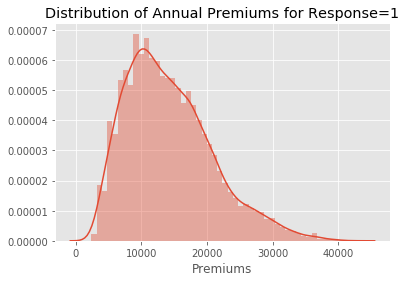

In [3159]:
sns.distplot(train[train['Response']==1]['Reco_Policy_Premium']);
plt.title("Distribution of Annual Premiums for Response=1");
plt.xlabel("Premiums");

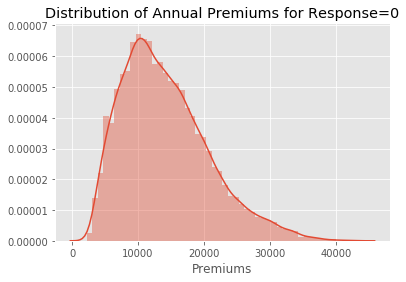

In [3160]:
sns.distplot(train[train['Response']==0]['Reco_Policy_Premium']);
plt.title("Distribution of Annual Premiums for Response=0");
plt.xlabel("Premiums");

The distribution of Policy Premiums look the same for both Response values. Both are slightly positively skewed distributions.

In [3161]:
# Let's see the insurance premiums for the Reco_Policy_Cat
train.groupby("Reco_Policy_Cat")['Reco_Policy_Premium'].agg(['count','min','max','mean','median','std'])

,count,min,max,mean,median,std
Reco_Policy_Cat,,,,,,
1,1734,2280.0,36812.8,12933.122722,12184.0,5761.086308
2,1820,2304.0,41496.0,12675.794505,11540.0,6031.447084
3,1038,3792.0,41040.0,15214.711946,14200.0,6789.582413
4,995,2624.0,38000.0,12319.512362,11502.0,5575.335468
5,961,2652.0,39456.0,16066.991675,15160.0,7038.886358
6,813,3020.0,42240.0,13284.424108,12204.0,6232.698366
7,822,2724.0,37734.0,15143.507299,13904.0,7294.862908
8,754,2700.0,36594.0,14469.129973,13607.0,6908.928819
9,753,2776.0,37331.2,13817.341567,12700.0,6339.313448


1. We can see that the mean policy premium is highest for reco_policy_cat value 5.
2. For most of the recommended policies the maximum value of policy premiums is less tan 40000 except a few (18-22),6,13,2,3.

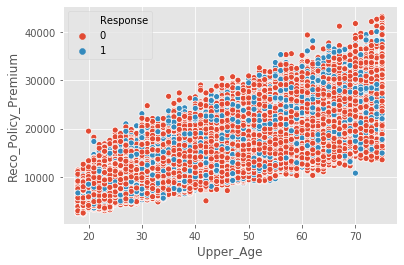

In [3162]:
# Let's check the scatter plot of Age Vs Policy Premium
sns.scatterplot(train['Upper_Age'],train['Reco_Policy_Premium'],hue=train['Response'])

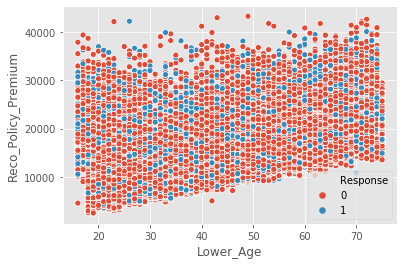

In [3163]:
# Let's check the scatter plot of Age Vs Policy Premium
sns.scatterplot(train['Lower_Age'],train['Reco_Policy_Premium'],hue=train['Response'])

We can see that as the Upper_Age increases, the Policy Premium also increases. 

The above behavior is not seen with respect to the lower_Age variable.

#### Correlation

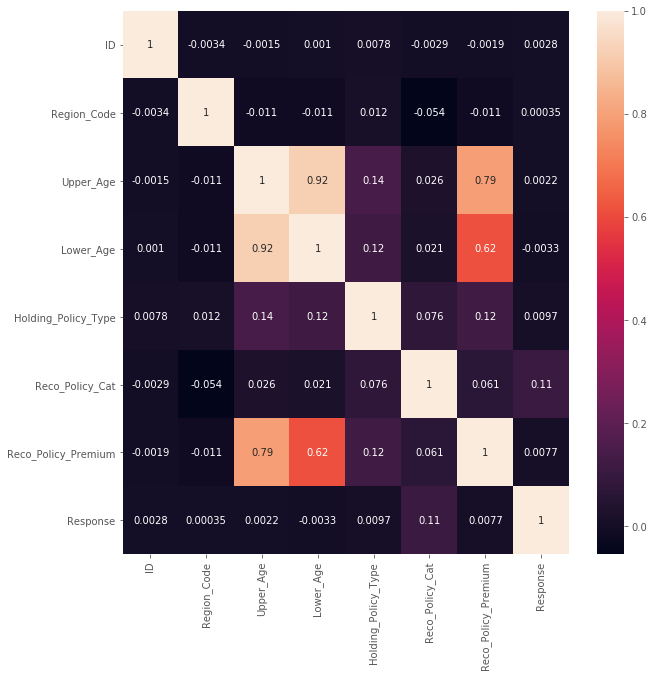

In [3164]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(),annot=True)

We can see that only the Reco_Policy_Cat variable has a better correlation with the Dependent variable. 

We can see that the Lower_Age and Upper_Age have some correlation with the Reco_Policy_Premium variable.

We can see that Lower_Age and Upper_Age are highly correlated with each other. 

In [3165]:
y = train['Response']
train.drop("Response",axis=1,inplace=True)

train['Source'] = "Train"
test['Source'] = "Test"

df = pd.concat([train,test],axis=0)
df.shape

(70557, 14)

#### Feature Generation

In [3166]:
# Replacing Upper_Age and Lower_Age with average_age
df['Max_Age'] = df[['Upper_Age','Lower_Age']].max(axis=0)
df.drop(['Lower_Age','Upper_Age'],axis=1,inplace=True)

# Filling missing values in Health Indicator variable and creating an indicator variable
df['Health_Indicator_isNA'] = df['Health Indicator'].isna()
df['Health Indicator'].fillna("Missing",inplace=True)

# Filling missing values in Holding_Policy_Duration and Holding_Policy_Type variables
df['Duration_Type_isNA'] = df['Holding_Policy_Duration'].isna()
df['Holding_Policy_Duration'].replace({"14+":15},inplace=True)
df['Holding_Policy_Duration'].fillna(0,inplace=True)
df['Holding_Policy_Duration'] = pd.to_numeric(df['Holding_Policy_Duration'])
df['Holding_Policy_Type'].fillna(0,inplace=True)

# Creating brackets for Age variable
def Age_Bracket(x):
    if (x>20 and x<30):
        return "20-30"
    elif (x>=30 and x<40):
        return "30-40"
    elif (x>=40 and x<50):
        return "40-50"
    elif (x>=50 and x<60):
        return "50-60"
    elif (x>=60 and x<70):
        return "60-70"
    else:
        return "70+"
df['Age_Bin'] = df['Max_Age'].apply(Age_Bracket)

# Creating brackets for Reco_Policy_Premium variable
def Reco_Policy_Premium_Bracket(x):
    if x<10000:
        return "Low"
    elif (x>=10000 and x<20000):
        return "Medium"
    elif (x>=20000 and x<30000):
        return "High"
    elif x>=30000:
        return "Very_High"
df['Reco_Policy_Premium_Bin'] = df['Reco_Policy_Premium'].apply(Reco_Policy_Premium_Bracket)

In [3167]:
df['Unique_Region_Code_Per_City_Code'] = df.groupby("City_Code")['Region_Code'].transform("nunique")
df['Unique_Region_Code_Per_Accomodation_Type'] = df.groupby("Accomodation_Type")['Region_Code'].transform("nunique")
df['Unique_Health_Indicator_Per_City_Code'] = df.groupby("City_Code")['Health Indicator'].transform("nunique")
df['Unique_Reco_Policy_Cat_Per_City_Code'] = df.groupby("City_Code")['Reco_Policy_Cat'].transform("nunique")
df['Unique_Region_Code_Per_Reco_Policy_Cat'] = df.groupby("Reco_Policy_Cat")['Region_Code'].transform("nunique")

In [3168]:
df['Mean_Reco_Policy_Premium_Per_City_Code'] = df.groupby('City_Code')['Reco_Policy_Premium'].transform("mean")
df['Mean_Reco_Policy_Premium_Per_Reco_Policy_Cat'] = df.groupby('Reco_Policy_Cat')['Reco_Policy_Premium'].transform("mean")
df['Mean_Reco_Policy_Premium_Per_Holding_Policy_Type'] = df.groupby('Holding_Policy_Type')['Reco_Policy_Premium'].transform("mean")
df['Mean_Reco_Policy_Premium_Per_Health_Indicator'] = df.groupby('Health Indicator')['Reco_Policy_Premium'].transform("mean")
#df['Mean_Reco_Policy_Premium_Per_Age_Bin'] = df.groupby('Age_Bin')['Reco_Policy_Premium'].transform("mean")
df['Mean_Premium_Per_Indicator_Reco_Policy_Cat'] = df.groupby(['Health Indicator','Reco_Policy_Cat'])['Reco_Policy_Premium'].transform("mean")

In [3169]:
df['Sum_Reco_Policy_Premium_Per_City_Code'] = df.groupby('City_Code')['Reco_Policy_Premium'].transform("sum")
df['Sum_Median_Reco_Policy_Premium_Per_Reco_Policy_Cat'] = df.groupby('Reco_Policy_Cat')['Reco_Policy_Premium'].transform("sum")
df['Sum_Reco_Policy_Premium_Per_Holding_Policy_Type'] = df.groupby('Holding_Policy_Type')['Reco_Policy_Premium'].transform("sum")
df['Sum_Reco_Policy_Premium_Per_Health_Indicator'] = df.groupby('Health Indicator')['Reco_Policy_Premium'].transform("sum")
#df['Sum_Reco_Policy_Premium_Per_Age_Bin'] = df.groupby('Age_Bin')['Reco_Policy_Premium'].transform("sum")
df['Sum_Premium_Per_Indicator_Reco_Policy_Cat'] = df.groupby(['Health Indicator','Reco_Policy_Cat'])['Reco_Policy_Premium'].transform("sum")

In [3170]:
df['Max_Reco_Policy_Premium_Per_City_Code'] = df.groupby('City_Code')['Reco_Policy_Premium'].transform("max")
df['Max_Reco_Policy_Premium_Per_Reco_Policy_Cat'] = df.groupby('Reco_Policy_Cat')['Reco_Policy_Premium'].transform("max")
df['Max_Reco_Policy_Premium_Per_Holding_Policy_Type'] = df.groupby('Holding_Policy_Type')['Reco_Policy_Premium'].transform("max")
df['Max_Reco_Policy_Premium_Per_Health_Indicator'] = df.groupby('Health Indicator')['Reco_Policy_Premium'].transform("max")
#df['Max_Reco_Policy_Premium_Per_Age_Bin'] = df.groupby('Age_Bin')['Reco_Policy_Premium'].transform("max")
df['Max_Premium_Per_Indicator_Reco_Policy_Cat'] = df.groupby(['Health Indicator','Reco_Policy_Cat'])['Reco_Policy_Premium'].transform("max")

In [3171]:
df['Min_Reco_Policy_Premium_Per_City_Code'] = df.groupby('City_Code')['Reco_Policy_Premium'].transform("min")
df['Min_Reco_Policy_Premium_Per_Reco_Policy_Cat'] = df.groupby('Reco_Policy_Cat')['Reco_Policy_Premium'].transform("min")
df['Min_Reco_Policy_Premium_Per_Holding_Policy_Type'] = df.groupby('Holding_Policy_Type')['Reco_Policy_Premium'].transform("min")
df['Min_Reco_Policy_Premium_Per_Health_Indicator'] = df.groupby('Health Indicator')['Reco_Policy_Premium'].transform("min")
#df['Min_Reco_Policy_Premium_Per_Age_Bin'] = df.groupby('Age_Bin')['Reco_Policy_Premium'].transform("min")
df['Min_Premium_Per_Indicator_Reco_Policy_Cat'] = df.groupby(['Health Indicator','Reco_Policy_Cat'])['Reco_Policy_Premium'].transform("min")

In [3172]:
df['Rank_City_Code_Premium'] = df.groupby("City_Code")['Reco_Policy_Premium'].rank(method='first',ascending=True)
df['Rank_Mean_City_Code_Premium'] = df.groupby("City_Code")['Reco_Policy_Premium'].rank(method='average',ascending=True)
df['Rank_Max_City_Code_Premium'] = df.groupby("City_Code")['Reco_Policy_Premium'].rank(method='max',ascending=True)
df['Rank_Min_City_Code_Premium'] = df.groupby("City_Code")['Reco_Policy_Premium'].rank(method='min',ascending=True)
df['Rank_Diff_City_Code_Premium'] = df['Rank_Max_City_Code_Premium']-df['Rank_Min_City_Code_Premium']

df['Rank_Health_Indicator_Premium'] = df.groupby("Health Indicator")['Reco_Policy_Premium'].rank(method='first',ascending=True)
df['Rank_Mean_Health_Indicator_Premium'] = df.groupby("Health Indicator")['Reco_Policy_Premium'].rank(method='average',ascending=True)
df['Rank_Max_Health_Indicator_Premium'] = df.groupby("Health Indicator")['Reco_Policy_Premium'].rank(method='max',ascending=True)
df['Rank_Min_Health_Indicator_Premium'] = df.groupby("Health Indicator")['Reco_Policy_Premium'].rank(method='min',ascending=True)
df['Rank_Diff_Health_Indicator_Premium'] = df['Rank_Max_Health_Indicator_Premium']-df['Rank_Min_Health_Indicator_Premium']

df['Rank_Reco_Policy_Cat_Premium'] = df.groupby("Reco_Policy_Cat")['Reco_Policy_Premium'].rank(method='first',ascending=True)
df['Rank_Mean_Reco_Policy_Cat_Premium'] = df.groupby("Reco_Policy_Cat")['Reco_Policy_Premium'].rank(method='average',ascending=True)
df['Rank_Max_Reco_Policy_Cat_Premium'] = df.groupby("Reco_Policy_Cat")['Reco_Policy_Premium'].rank(method='max',ascending=True)
df['Rank_Min_Reco_Policy_Cat_Premium'] = df.groupby("Reco_Policy_Cat")['Reco_Policy_Premium'].rank(method='min',ascending=True)
df['Rank_Diff_Reco_Policy_Cat_Premium'] = df['Rank_Max_Reco_Policy_Cat_Premium']-df['Rank_Min_Reco_Policy_Cat_Premium']

df['Rank_Age_Bin_Premium'] = df.groupby("Age_Bin")['Reco_Policy_Premium'].rank(method='first',ascending=True)
df['Rank_Mean_Age_Bin_Premium'] = df.groupby("Age_Bin")['Reco_Policy_Premium'].rank(method='average',ascending=True)
df['Rank_Max_Age_Bin_Premium'] = df.groupby("Age_Bin")['Reco_Policy_Premium'].rank(method='max',ascending=True)
df['Rank_Min_Age_Bin_Premium'] = df.groupby("Age_Bin")['Reco_Policy_Premium'].rank(method='min',ascending=True)
df['Rank_Diff_Age_Bin_Premium'] = df['Rank_Max_Age_Bin_Premium']-df['Rank_Min_Age_Bin_Premium']

df['Rank_Indicator_Reco_Policy_Cat_Premium'] = df.groupby(['Health Indicator','Reco_Policy_Cat'])['Reco_Policy_Premium'].rank(method='first',ascending=True)
df['Rank_Mean_Indicator_Reco_Policy_Cat_Premium'] = df.groupby(['Health Indicator','Reco_Policy_Cat'])['Reco_Policy_Premium'].rank(method='average',ascending=True)
df['Rank_Max_Indicator_Reco_Policy_Cat_Premium'] = df.groupby(['Health Indicator','Reco_Policy_Cat'])['Reco_Policy_Premium'].rank(method='max',ascending=True)
df['Rank_Min_Indicator_Reco_Policy_Cat_Premium'] = df.groupby(['Health Indicator','Reco_Policy_Cat'])['Reco_Policy_Premium'].rank(method='min',ascending=True)
df['Rank_Diff_Indicator_Reco_Policy_Cat_Premium'] = df['Rank_Max_Indicator_Reco_Policy_Cat_Premium']-df['Rank_Min_Indicator_Reco_Policy_Cat_Premium']

In [3173]:
df['Customers_Per_City_Code'] = df.groupby("City_Code")['ID'].transform("count")
df['Customers_Per_Region'] = df.groupby("Region_Code")['ID'].transform("count")
df['Customers_Per_Health_Indicator'] = df.groupby("Health Indicator")['ID'].transform("count")
df['Customers_Per_Holding_Policy_Type'] = df.groupby("Holding_Policy_Type")['ID'].transform("count")
df['Customers_Per_Reco_Policy_Cat'] = df.groupby("Reco_Policy_Cat")['ID'].transform("count")

In [3174]:
# Analysis shows that customers with Individual reco_iinsurance_type and is_spouse value of no have high response rate
df['Reco_Insurance_Type_Is_Spouse'] = np.where((df['Reco_Insurance_Type']=="Individual")&(df['Is_Spouse']=="No"),0,1)

In [3175]:
df['Accomodation_Type'].replace({"Rented":1,"Owned":0},inplace=True)
df['Reco_Insurance_Type'].replace({"Individual":0,"Joint":1},inplace=True)
df['Is_Spouse'].replace({"Yes":1,"No":0},inplace=True)

df['Reco_Policy_Premium'] = np.log(df['Reco_Policy_Premium'])

le = LabelEncoder()
for col in ['City_Code','Health Indicator','Age_Bin','Reco_Policy_Premium_Bin','Region_Code']:
    df[col] = le.fit_transform(df[col])

In [3176]:
train = df[df['Source']=="Train"]
test = df[df['Source']=="Test"]

for df in [train,test]:
    df.drop(['Source','ID'],axis=1,inplace=True)

In [3177]:
cat_cols = ['City_Code','Accomodation_Type','Reco_Insurance_Type','Is_Spouse','Health Indicator','Holding_Policy_Type','Reco_Policy_Cat',
            'Age_Bin','Reco_Policy_Premium_Bin','Region_Code']

In [3178]:
X = train

In [3179]:
lgb_predictions = np.zeros(test.shape[0])
folds = StratifiedKFold(n_splits=10,random_state=42,shuffle=True)
roc_score = []
for train_index,test_index in folds.split(X,y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    clf = lgb.LGBMClassifier(objective='binary',
                             n_jobs=-1,
                             boosting_type="gbdt",
                             learning_rate=0.05,
                             n_estimators=500,
                             subsample=0.9,
                             colsample_bytree=0.7,
                             reg_lambda=0.5,
                             reg_alpha=0.5,
                             min_child_samples=5,
                             is_unbalanced="True",
                             max_depth=12,
                             num_leaves=100)
    
    clf.fit(x_train,
            y_train,
            eval_set=[(x_val,y_val)],
            early_stopping_rounds=50,
            verbose=100,
            categorical_feature = cat_cols,
            eval_metric=['auc'])
    
    
    preds = clf.predict_proba(x_val)[:, 1]
    score = roc_auc_score(y_val,preds)
    print ("Validation ROC AUC Score:",score)
    print ("------------------------------------------------")
    roc_score.append(score)
    
    
    # Predicting on the test set
    lgb_predictions += clf.predict_proba(test)[:, 1] / folds.n_splits
    
print ("------------------------------------------")
print ("Mean ROC AUC Score of 10 Folds:",np.mean(np.array(roc_score)))

C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Accomodation_Type', 'Age_Bin', 'City_Code', 'Health Indicator', 'Holding_Policy_Type', 'Is_Spouse', 'Reco_Insurance_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium_Bin', 'Region_Code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.69023	valid_0's binary_logloss: 0.506542
Early stopping, best iteration is:
[54]	valid_0's auc: 0.690615	valid_0's binary_logloss: 0.507589
Validation ROC AUC Score: 0.6906150110008717
------------------------------------------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Accomodation_Type', 'Age_Bin', 'City_Code', 'Health Indicator', 'Holding_Policy_Type', 'Is_Spouse', 'Reco_Insurance_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium_Bin', 'Region_Code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.697013	valid_0's binary_logloss: 0.517027
Validation ROC AUC Score: 0.6970132748465183
------------------------------------------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Accomodation_Type', 'Age_Bin', 'City_Code', 'Health Indicator', 'Holding_Policy_Type', 'Is_Spouse', 'Reco_Insurance_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium_Bin', 'Region_Code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.707387	valid_0's binary_logloss: 0.498741
Early stopping, best iteration is:
[110]	valid_0's auc: 0.70815	valid_0's binary_logloss: 0.498176
Validation ROC AUC Score: 0.7081495016289217
------------------------------------------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Accomodation_Type', 'Age_Bin', 'City_Code', 'Health Indicator', 'Holding_Policy_Type', 'Is_Spouse', 'Reco_Insurance_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium_Bin', 'Region_Code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.700774	valid_0's binary_logloss: 0.504011
Early stopping, best iteration is:
[87]	valid_0's auc: 0.701058	valid_0's binary_logloss: 0.503379
Validation ROC AUC Score: 0.7010580258033006
------------------------------------------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Accomodation_Type', 'Age_Bin', 'City_Code', 'Health Indicator', 'Holding_Policy_Type', 'Is_Spouse', 'Reco_Insurance_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium_Bin', 'Region_Code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's auc: 0.687908	valid_0's binary_logloss: 0.511943
Validation ROC AUC Score: 0.6879084710849677
------------------------------------------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Accomodation_Type', 'Age_Bin', 'City_Code', 'Health Indicator', 'Holding_Policy_Type', 'Is_Spouse', 'Reco_Insurance_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium_Bin', 'Region_Code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's auc: 0.689391	valid_0's binary_logloss: 0.511701
Validation ROC AUC Score: 0.6893905889554635
------------------------------------------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Accomodation_Type', 'Age_Bin', 'City_Code', 'Health Indicator', 'Holding_Policy_Type', 'Is_Spouse', 'Reco_Insurance_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium_Bin', 'Region_Code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.689657	valid_0's binary_logloss: 0.507274
Early stopping, best iteration is:
[88]	valid_0's auc: 0.690387	valid_0's binary_logloss: 0.50678
Validation ROC AUC Score: 0.6903865924769073
------------------------------------------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Accomodation_Type', 'Age_Bin', 'City_Code', 'Health Indicator', 'Holding_Policy_Type', 'Is_Spouse', 'Reco_Insurance_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium_Bin', 'Region_Code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.696208	valid_0's binary_logloss: 0.503805
Early stopping, best iteration is:
[55]	valid_0's auc: 0.697777	valid_0's binary_logloss: 0.504298
Validation ROC AUC Score: 0.6977773310060166
------------------------------------------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Accomodation_Type', 'Age_Bin', 'City_Code', 'Health Indicator', 'Holding_Policy_Type', 'Is_Spouse', 'Reco_Insurance_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium_Bin', 'Region_Code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's auc: 0.705962	valid_0's binary_logloss: 0.504974
Validation ROC AUC Score: 0.705961756234659
------------------------------------------------


C:\Users\kulka\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Accomodation_Type', 'Age_Bin', 'City_Code', 'Health Indicator', 'Holding_Policy_Type', 'Is_Spouse', 'Reco_Insurance_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium_Bin', 'Region_Code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.698034	valid_0's binary_logloss: 0.503669
[200]	valid_0's auc: 0.706248	valid_0's binary_logloss: 0.500929
[300]	valid_0's auc: 0.710512	valid_0's binary_logloss: 0.501506
Early stopping, best iteration is:
[259]	valid_0's auc: 0.711133	valid_0's binary_logloss: 0.49997
Validation ROC AUC Score: 0.7111331265462291
------------------------------------------------
------------------------------------------
Mean ROC AUC Score of 10 Folds: 0.6979393679583855


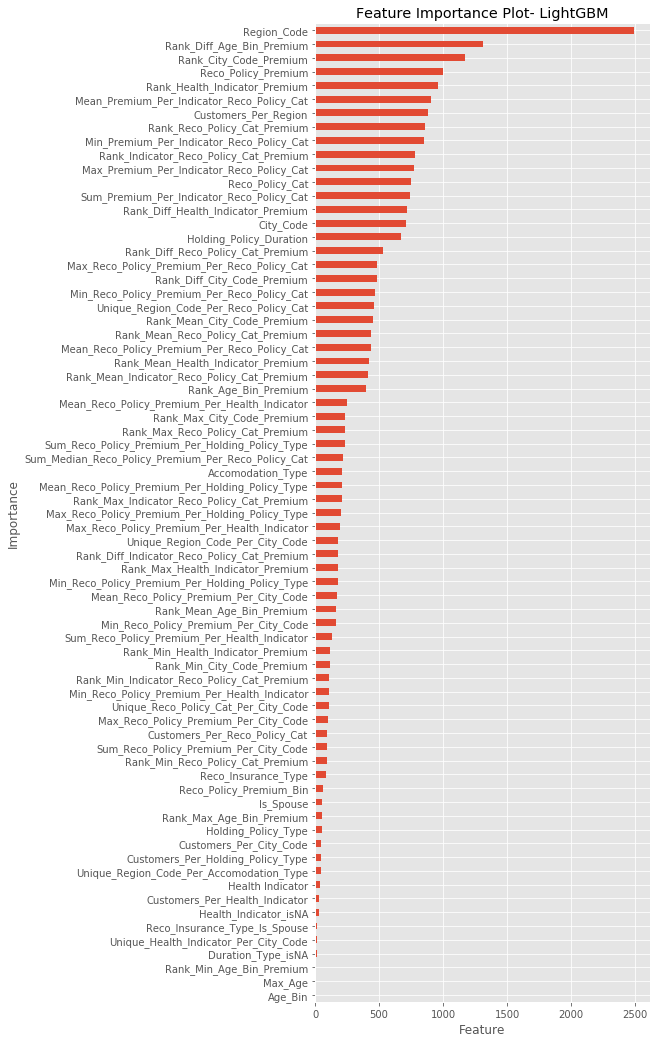

In [3180]:
# plotting Feature Importance
plt.figure(figsize=(6,18));
ser = pd.Series(clf.feature_importances_,X.columns).sort_values();
ser.plot(kind='barh');
plt.title("Feature Importance Plot- LightGBM");
plt.xlabel("Feature");
plt.ylabel("Importance");

Text(0.5, 0, 'False positive rate')

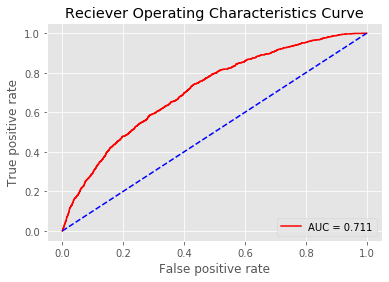

In [3181]:
probability = clf.predict_proba(x_val)[:,1]
frp,trp, threshold = roc_curve(y_val,probability)
roc_auc_ = auc(frp,trp)
plt.title('Reciever Operating Characteristics Curve')
plt.plot(frp,trp,'r',label = 'AUC = %0.3f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

In [3182]:
Submission['Response'] = lgb_predictions
Submission.to_csv("Sol_4.csv",index=None)

In [3183]:
Submission.head()

,ID,Response
0,50883,0.362303
1,50884,0.196182
2,50885,0.159353
3,50886,0.249566
4,50887,0.279108
